# Homework 3 - Deep Reinforcement Learning

---
A.A. 2021/22, Borella Lorenzo, mat. 2012266
---

* 3 pt: use the notebook of Lab 07 to study how the exploration profile (either using eps-greedy or softmax) impacts the learning curve. Tune a bit the model hyperparameters or tweak the reward function to speed-up learning convergence (i.e., reach the same accuracy with fewer training episodes).

* 5 pt: extend the notebook used in Lab 07, in order to learn to control the CartPole environment using directly the screen pixels, rather than the compact state representation used during the Lab (cart position, cart velocity, pole angle, pole angular velocity). NB: this will require to change the “observation_space” and to look for smart ways of encoding the pixels in a compact way to reduce computational complexity (e.g., crop the image around the pole, use difference of consecutive frames as input to consider temporal context, etc.).


or

* 5 pt: train a deep RL agent on a different Gym environment. You are free to choose whatever Gym environment you like from the available list, or even explore other simulation platforms.



The following notebook has been written starting from the examples studied in Notebook 7 during classes. Some modifications and improvements have been introduced, as well as some deeper studies regarding the behaviour of Reinforcement Learning.

In [1]:
!pip install gym
!pip install optuna
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.2 MB/s 
     |████████████████████████████████| 209 kB 58.3 MB/s 
     |████████████████████████████████| 81 kB 10.2 MB/s 
     |████████████████████████████████| 78 kB 7.1 MB/s 
     |████████████████████████████████| 112 kB 71.5 MB/s 
     |████████████████████████████████| 147 kB 49.2 MB/s 
     |████████████████████████████████| 49 kB 3.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1a9af450b319d5539bb100c912422f3a4cb2ba6439830776b55a75f06aed5ed0
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█████

In [2]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque 
import optuna

In [3]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [91.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,540 kB]
G

In [4]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import RecordEpisodeStatistics,RecordVideo #instead of original Monitor 

In [5]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [6]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [7]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = RecordVideo(env,'./video',None, None,100,"rl-video")
  return env

#1) Classes and functions

The following cells report the classes and function definitions coming from Notebook 7. They will be used in the following for the implementation of two different gym environments and deep reinfoorcement learning agents. 

## 1.1) Replay Memory

In [8]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## 1.2) Policy Network

In [9]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim,128),nn.Tanh(),
                nn.Linear(128,128),nn.Tanh(),
                nn.Linear(128,action_space_dim),nn.ReLU()
                )

    def forward(self, x):
        return self.linear(x)

## 1.3) Exploration Policy

### 1.3.1)Eps greedy

In [10]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())

    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
      
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]

        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

### 1.3.2)Softmax 

In [11]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

## 1.4) Exploration Profile

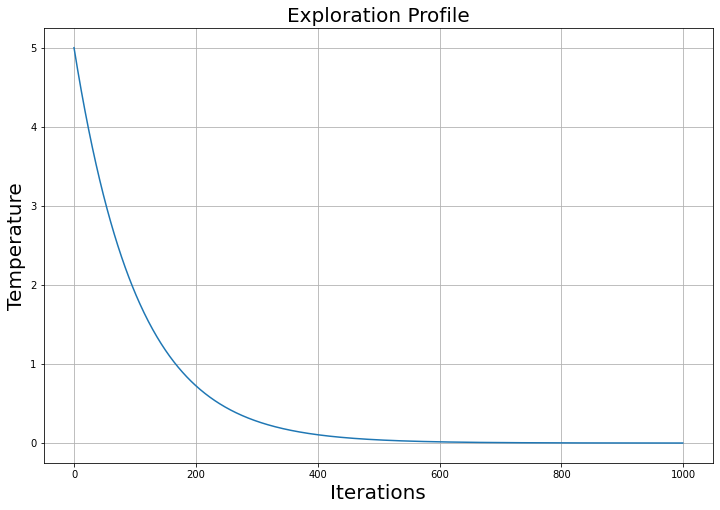

In [12]:
### Define exploration profile
def exp_profile(initial_value=5, num_iterations=1000, tau=6):
  exp_decay = np.exp(-np.log(initial_value) / num_iterations * tau) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
  profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
  return profile

### Plot exploration profile
exploration_profile = exp_profile()
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.xlabel('Iterations',fontsize=20)
plt.ylabel('Temperature',fontsize=20)
plt.title("Exploration Profile",fontsize=20)
plt.grid()
plt.show()

## 1.5) Gym Environment (DISCARD)

In [13]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.reset(seed=0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


## 1.6) Network update

In [14]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)

    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)

    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]


    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

##1.7) Training Loop

In [31]:
def training_loop(env,policy,epsilon,tau,num_iterations,param_dict):

  #read
  min_samples_for_training = param_dict['min_samples_for_training']
  bad_state_penalty = param_dict['bad_state_penalty']
  target_net_update_steps = param_dict['target_net_update_steps']
  gamma = param_dict['gamma']
  batch_size = param_dict['batch_size']

  #store score values
  scores = []

  #profile
  exploration_profile = exp_profile(initial_value=5, num_iterations=num_iterations, tau=6)

  for episode_num, tau in enumerate(tqdm(exploration_profile)):

      # Reset the environment and get the initial state
      state = env.reset()

      # Reset the score. The final score will be the total amount of steps before the pole falls
      score = 0
      done = False

      # Go on until the pole falls off
      while not done:

        # Choose the action following the policy
        if policy=='eps':
          action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon)
        elif policy=='softmax':
          action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
        
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Set the current state for the next iteration
        state = next_state

      #store score values per episode
      scores.append(score)

      # Update the target network every target_net_update_steps episodes
      if episode_num % target_net_update_steps == 0:
          print('Updating target network...')
          target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

      # Print the final score
      if policy=='eps':
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score}")

      elif policy=='softmax':
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") 

  env.close()

  return scores

## 1.8) Initializer

In [19]:
### Initialize the replay memory
def initializer(param_dict,env_name='CartPole-v1' ):

  ### Create environment
  env = gym.make(env_name) # Initialize the Gym environment
  env.reset(seed=0) # Set a random seed for the environment (reproducible results)

  # Get the shapes of the state space (observation_space) and action space (action_space)
  state_space_dim = env.observation_space.shape[0]
  action_space_dim = env.action_space.n

  #read params from dict
  replay_memory_capacity = param_dict['replay_memory_capacity']
  lr = param_dict['lr']

  #initialiize Replay Memory
  replay_mem = ReplayMemory(replay_memory_capacity)    

  ### Initialize the policy network
  policy_net = DQN(state_space_dim, action_space_dim)

  ### Initialize the target network with the same weights of the policy network
  target_net = DQN(state_space_dim, action_space_dim)
  target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

  ### Initialize the optimizer
  optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

  ### Initialize the loss function (Huber loss) 
  loss_fn = nn.SmoothL1Loss()

  return env, replay_mem, policy_net, target_net, optimizer, loss_fn

#2) Test

In [32]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

param_dict = {             
  'gamma' : 0.97,   # gamma parameter for the long term reward
  'replay_memory_capacity' : 10000,   # Replay memory capacity
  'lr' : 1e-2,  # Optimizer learning rate
  'target_net_update_steps' : 10,   # Number of episodes to wait before updating the target network
  'batch_size' :  128,  # Number of samples to take from the replay memory for each update
  'bad_state_penalty' : 0,   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
  'min_samples_for_training' : 1000,  # Minimum samples in the replay memory to enable the training
  'policy' : 'softmax',
  'epsilon' : 0.25,
  'tau' : 6
  }

#INITIALIZE
env, replay_mem, policy_net, target_net, optimizer, loss_fn = initializer(param_dict,env_name='CartPole-v1' )

#TRAIN
learning_curve = training_loop(env,policy='softmax',epsilon=0.25,tau=6,num_iterations=1000,param_dict=param_dict)


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 18 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 51 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 38 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 21 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 22 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 21 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 34 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 18 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 14 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 20 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 18 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 20 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 20 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 26 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


EPISODE: 46 - FINAL SCORE: 73 - Temperature: 3.237785718910413
EPISODE: 47 - FINAL SCORE: 29 - Temperature: 3.206670106116043
EPISODE: 48 - FINAL SCORE: 17 - Temperature: 3.175853519089164
EPISODE: 49 - FINAL SCORE: 16 - Temperature: 3.145333084146709
EPISODE: 50 - FINAL SCORE: 11 - Temperature: 3.115105955222141
Updating target network...
EPISODE: 51 - FINAL SCORE: 19 - Temperature: 3.0851693136000553
EPISODE: 52 - FINAL SCORE: 50 - Temperature: 3.0555203676533305
EPISODE: 53 - FINAL SCORE: 13 - Temperature: 3.0261563525828072
EPISODE: 54 - FINAL SCORE: 34 - Temperature: 2.9970745301594635
EPISODE: 55 - FINAL SCORE: 11 - Temperature: 2.9682721884690775
EPISODE: 56 - FINAL SCORE: 13 - Temperature: 2.939746641659333
EPISODE: 57 - FINAL SCORE: 15 - Temperature: 2.911495229689364
EPISODE: 58 - FINAL SCORE: 14 - Temperature: 2.8835153180817
EPISODE: 59 - FINAL SCORE: 17 - Temperature: 2.855804297676601
EPISODE: 60 - FINAL SCORE: 17 - Temperature: 2.828359584388748
Updating target network..

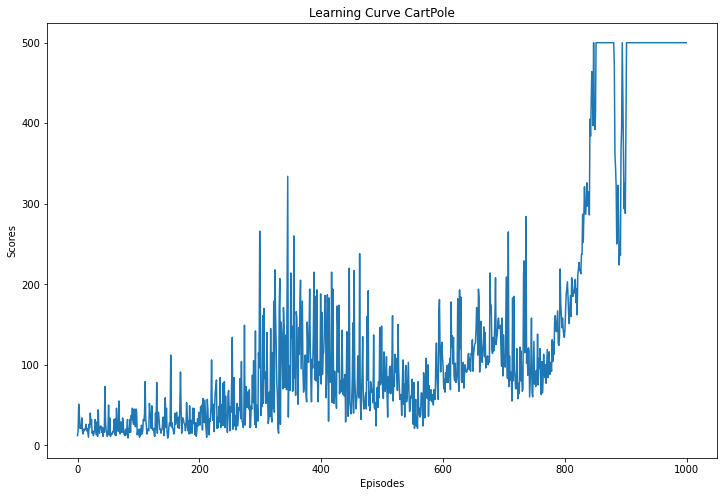

In [33]:
plt.figure(1,figsize=(12,8))
plt.plot(learning_curve)
plt.title("Learning Curve CartPole")
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.show()

In [34]:
show_videos()

# 3) Comparison: Exploration policies

## EPS greedy: Dfferent EPS

In [38]:
#define exploration profile
profile = exp_profile(5,500,6)

epsilons = [0.25,0.5,0.75,1]
greedy_learning_curves = []

for i in range(4):

  #select epsilon value
  eps = epsilons[i]

  param_dict = {             
  'gamma' : 0.97,   # gamma parameter for the long term reward
  'replay_memory_capacity' : 10000,   # Replay memory capacity
  'lr' : 1e-2,  # Optimizer learning rate
  'target_net_update_steps' : 10,   # Number of episodes to wait before updating the target network
  'batch_size' :  128,  # Number of samples to take from the replay memory for each update
  'bad_state_penalty' : 0,   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
  'min_samples_for_training' : 1000,  # Minimum samples in the replay memory to enable the training
  'policy' : 'softmax',
  'epsilon' : eps,
  'tau' : 6
  }

  #INITIALIZE
  env, replay_mem, policy_net, target_net, optimizer, loss_fn = initializer(param_dict,env_name='CartPole-v1' )

  #TRAIN
  learning_curve = training_loop(env,policy='eps',epsilon=eps,tau=6,num_iterations=1000,param_dict=param_dict)

  #store learning curves
  greedy_learning_curves.append(learning_curve)


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 10
EPISODE: 2 - FINAL SCORE: 12
EPISODE: 3 - FINAL SCORE: 19
EPISODE: 4 - FINAL SCORE: 11
EPISODE: 5 - FINAL SCORE: 11
EPISODE: 6 - FINAL SCORE: 9
EPISODE: 7 - FINAL SCORE: 10
EPISODE: 8 - FINAL SCORE: 9
EPISODE: 9 - FINAL SCORE: 35
EPISODE: 10 - FINAL SCORE: 9
Updating target network...
EPISODE: 11 - FINAL SCORE: 11
EPISODE: 12 - FINAL SCORE: 15
EPISODE: 13 - FINAL SCORE: 17
EPISODE: 14 - FINAL SCORE: 17
EPISODE: 15 - FINAL SCORE: 16
EPISODE: 16 - FINAL SCORE: 11
EPISODE: 17 - FINAL SCORE: 9
EPISODE: 18 - FINAL SCORE: 9
EPISODE: 19 - FINAL SCORE: 12
EPISODE: 20 - FINAL SCORE: 9
Updating target network...
EPISODE: 21 - FINAL SCORE: 9
EPISODE: 22 - FINAL SCORE: 14
EPISODE: 23 - FINAL SCORE: 15
EPISODE: 24 - FINAL SCORE: 9
EPISODE: 25 - FINAL SCORE: 9
EPISODE: 26 - FINAL SCORE: 14
EPISODE: 27 - FINAL SCORE: 14
EPISODE: 28 - FINAL SCORE: 9
EPISODE: 29 - FINAL SCORE: 10
EPISODE: 30 - FINAL SCORE: 17
Updating target network...
EPISODE: 31

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 14
EPISODE: 2 - FINAL SCORE: 32
EPISODE: 3 - FINAL SCORE: 15
EPISODE: 4 - FINAL SCORE: 17
EPISODE: 5 - FINAL SCORE: 16
EPISODE: 6 - FINAL SCORE: 23
EPISODE: 7 - FINAL SCORE: 13
EPISODE: 8 - FINAL SCORE: 16
EPISODE: 9 - FINAL SCORE: 18
EPISODE: 10 - FINAL SCORE: 11
Updating target network...
EPISODE: 11 - FINAL SCORE: 15
EPISODE: 12 - FINAL SCORE: 13
EPISODE: 13 - FINAL SCORE: 25
EPISODE: 14 - FINAL SCORE: 19
EPISODE: 15 - FINAL SCORE: 35
EPISODE: 16 - FINAL SCORE: 11
EPISODE: 17 - FINAL SCORE: 15
EPISODE: 18 - FINAL SCORE: 30
EPISODE: 19 - FINAL SCORE: 9
EPISODE: 20 - FINAL SCORE: 22
Updating target network...
EPISODE: 21 - FINAL SCORE: 15
EPISODE: 22 - FINAL SCORE: 42
EPISODE: 23 - FINAL SCORE: 9
EPISODE: 24 - FINAL SCORE: 20
EPISODE: 25 - FINAL SCORE: 19
EPISODE: 26 - FINAL SCORE: 14
EPISODE: 27 - FINAL SCORE: 12
EPISODE: 28 - FINAL SCORE: 16
EPISODE: 29 - FINAL SCORE: 19
EPISODE: 30 - FINAL SCORE: 21
Updating target network...
EPI

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 11
EPISODE: 2 - FINAL SCORE: 11
EPISODE: 3 - FINAL SCORE: 11
EPISODE: 4 - FINAL SCORE: 12
EPISODE: 5 - FINAL SCORE: 12
EPISODE: 6 - FINAL SCORE: 16
EPISODE: 7 - FINAL SCORE: 22
EPISODE: 8 - FINAL SCORE: 11
EPISODE: 9 - FINAL SCORE: 17
EPISODE: 10 - FINAL SCORE: 16
Updating target network...
EPISODE: 11 - FINAL SCORE: 16
EPISODE: 12 - FINAL SCORE: 34
EPISODE: 13 - FINAL SCORE: 11
EPISODE: 14 - FINAL SCORE: 10
EPISODE: 15 - FINAL SCORE: 9
EPISODE: 16 - FINAL SCORE: 10
EPISODE: 17 - FINAL SCORE: 10
EPISODE: 18 - FINAL SCORE: 17
EPISODE: 19 - FINAL SCORE: 13
EPISODE: 20 - FINAL SCORE: 16
Updating target network...
EPISODE: 21 - FINAL SCORE: 12
EPISODE: 22 - FINAL SCORE: 19
EPISODE: 23 - FINAL SCORE: 8
EPISODE: 24 - FINAL SCORE: 14
EPISODE: 25 - FINAL SCORE: 13
EPISODE: 26 - FINAL SCORE: 11
EPISODE: 27 - FINAL SCORE: 14
EPISODE: 28 - FINAL SCORE: 11
EPISODE: 29 - FINAL SCORE: 16
EPISODE: 30 - FINAL SCORE: 22
Updating target network...
EPI

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 16
EPISODE: 2 - FINAL SCORE: 16
EPISODE: 3 - FINAL SCORE: 16
EPISODE: 4 - FINAL SCORE: 13
EPISODE: 5 - FINAL SCORE: 16
EPISODE: 6 - FINAL SCORE: 21
EPISODE: 7 - FINAL SCORE: 16
EPISODE: 8 - FINAL SCORE: 15
EPISODE: 9 - FINAL SCORE: 18
EPISODE: 10 - FINAL SCORE: 15
Updating target network...
EPISODE: 11 - FINAL SCORE: 13
EPISODE: 12 - FINAL SCORE: 17
EPISODE: 13 - FINAL SCORE: 13
EPISODE: 14 - FINAL SCORE: 12
EPISODE: 15 - FINAL SCORE: 12
EPISODE: 16 - FINAL SCORE: 13
EPISODE: 17 - FINAL SCORE: 17
EPISODE: 18 - FINAL SCORE: 15
EPISODE: 19 - FINAL SCORE: 19
EPISODE: 20 - FINAL SCORE: 16
Updating target network...
EPISODE: 21 - FINAL SCORE: 18
EPISODE: 22 - FINAL SCORE: 20
EPISODE: 23 - FINAL SCORE: 20
EPISODE: 24 - FINAL SCORE: 19
EPISODE: 25 - FINAL SCORE: 18
EPISODE: 26 - FINAL SCORE: 15
EPISODE: 27 - FINAL SCORE: 16
EPISODE: 28 - FINAL SCORE: 17
EPISODE: 29 - FINAL SCORE: 17
EPISODE: 30 - FINAL SCORE: 19
Updating target network...
E

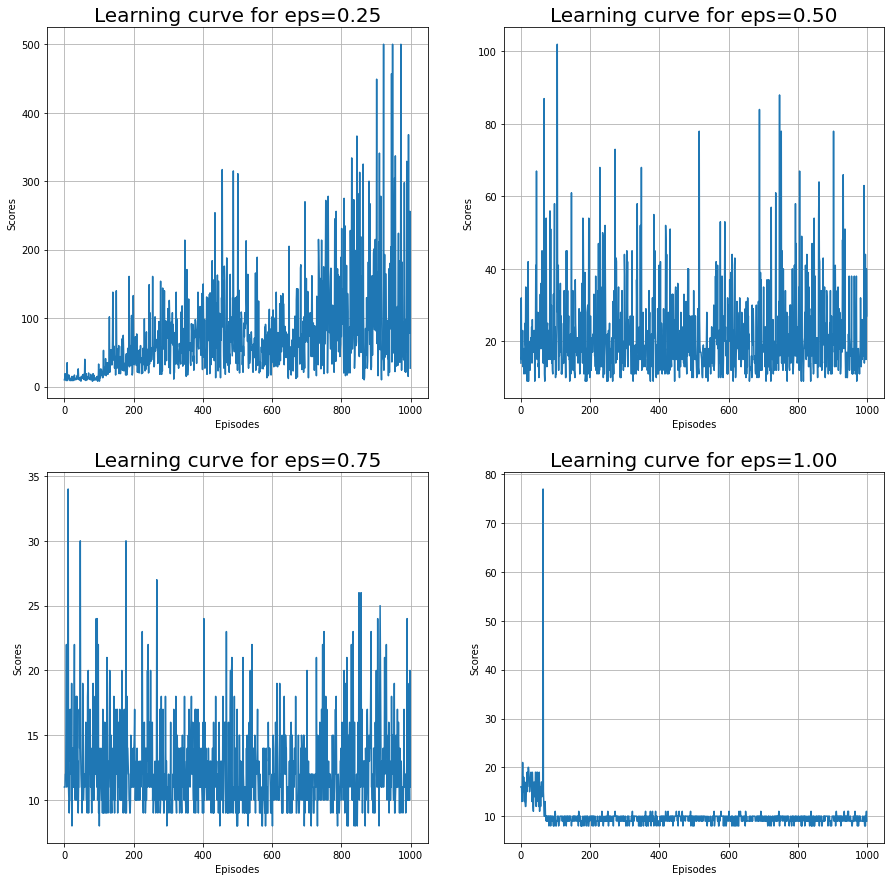

In [42]:
fig,ax = plt.subplots(2,2,figsize=(15,15))

for i in range(2):
  for j in range(2):
    #plot learning curves
    ax[i,j].plot(greedy_learning_curves[2*i+j],label="Learning Curve")
    ax[i,j].set_title("Learning curve for eps=%.2f"%epsilons[2*i+j],fontsize=20)
    ax[i,j].set_xlabel("Episodes",fontsize=10)
    ax[i,j].set_ylabel("Scores",fontsize=10)
    ax[i,j].grid()

plt.show()

## SOFTMAX: different exp decay

In [43]:
taus = [2,4,6,8]
softmax_learning_curves = []

for i in range(len(taus)):

  #select tau
  tau=taus[i]

  #define exploration profile
  profile = exp_profile(5,500,tau)

  param_dict = {             
  'gamma' : 0.97,   # gamma parameter for the long term reward
  'replay_memory_capacity' : 10000,   # Replay memory capacity
  'lr' : 1e-2,  # Optimizer learning rate
  'target_net_update_steps' : 10,   # Number of episodes to wait before updating the target network
  'batch_size' :  128,  # Number of samples to take from the replay memory for each update
  'bad_state_penalty' : 0,   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
  'min_samples_for_training' : 1000,  # Minimum samples in the replay memory to enable the training
  'policy' : 'softmax',
  'epsilon' : eps,
  'tau' : tau
  }

  #INITIALIZE
  env, replay_mem, policy_net, target_net, optimizer, loss_fn = initializer(param_dict,env_name='CartPole-v1' )

  #TRAIN
  learning_curve = training_loop(env,policy='softmax',epsilon=eps,tau=tau,num_iterations=1000,param_dict=param_dict)

  #store learning curves
  softmax_learning_curves.append(learning_curve)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 28 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 16 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 23 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 27 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 20 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 17 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 22 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 42 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 18 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 23 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 24 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 11 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 18 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 16 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 12 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 13 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 28 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 27 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 41 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 11 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 30 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 23 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 22 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 22 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 14 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 20 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 33 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 17 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 37 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 14 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 25 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 20 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 22 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 42 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 14 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 16 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 17 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 13 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 13 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 20 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 16 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 51 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 18 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 18 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 20 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 17 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 18 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 20 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 59 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 23 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 16 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 40 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 21 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 13 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 28 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 27 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 41 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

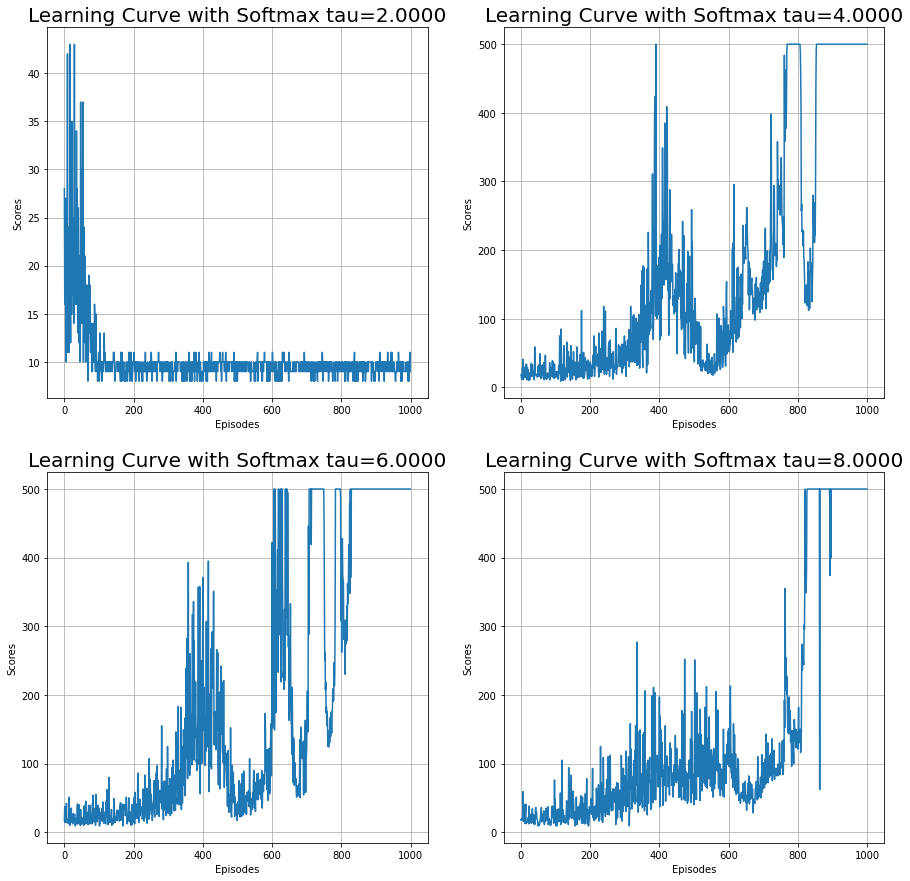

In [46]:
fig,ax = plt.subplots(2,2,figsize=(15,15))

for i in range(2):
  for j in range(2):
    #plot learning curves
    ax[i,j].plot(softmax_learning_curves[2*i+j],label="Learning Curve")
    ax[i,j].set_title("Learning Curve with Softmax tau=%.4f"%taus[2*i+j], fontsize=20)
    ax[i,j].set_xlabel("Episodes",fontsize=10)
    ax[i,j].set_ylabel("Scores",fontsize=10)
    ax[i,j].grid()

plt.show()

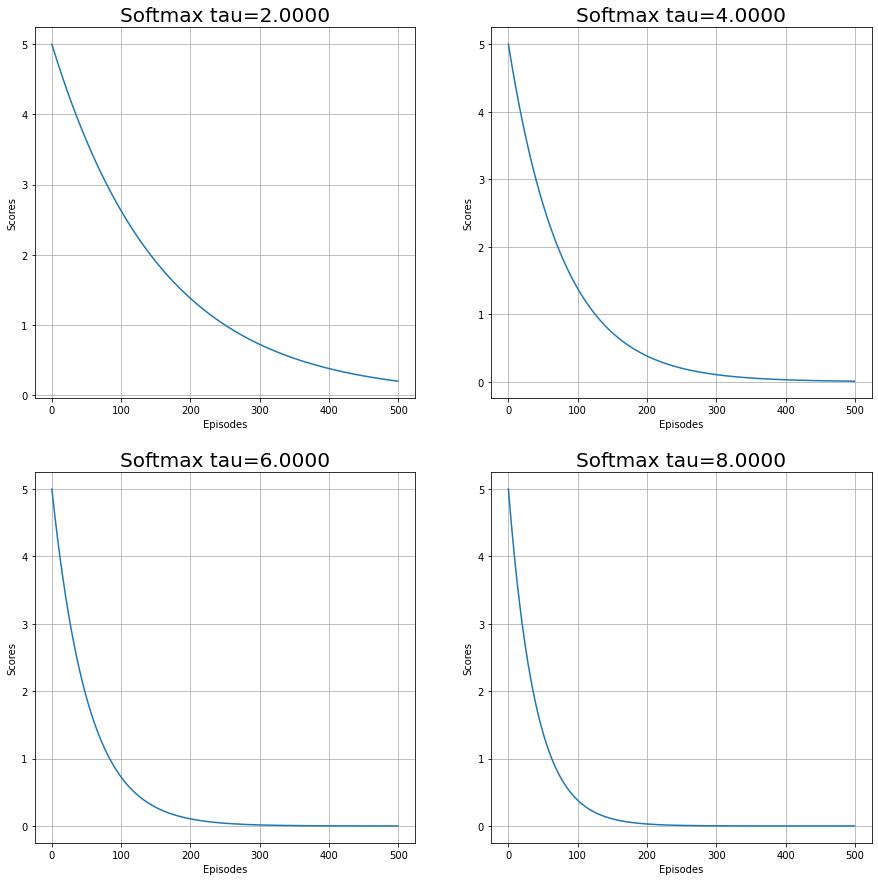

In [47]:
fig,ax = plt.subplots(2,2,figsize=(15,15))

for i in range(2):
  for j in range(2):

    #profiles
    tau = taus[2*i+j]
    profile = exp_profile(5,500,tau)

    #plot learning curves
    ax[i,j].plot(profile,label="Temperatures")
    ax[i,j].set_title("Softmax tau=%.4f"%taus[2*i+j],fontsize=20)
    ax[i,j].set_xlabel("Episodes",fontsize=10)
    ax[i,j].set_ylabel("Scores",fontsize=10)
    ax[i,j].grid()

plt.show()

#4)  Optuna optimization

In [52]:
def objective(trial):

  param_dict = {             
  'gamma' : trial.suggest_float('gamma', 0.94, 0.98), #0.97,   # gamma parameter for the long term reward
  'replay_memory_capacity' : 10000,   # Replay memory capacity
  'lr' : trial.suggest_loguniform('lr',1e-3, 5e-1),  # Optimizer learning rate
  'target_net_update_steps' : trial.suggest_categorical('target_net_update_steps', [5,10]), #10,   # Number of episodes to wait before updating the target network
  'batch_size' :  trial.suggest_categorical('batch_size', [128,256]),  # Number of samples to take from the replay memory for each update
  'bad_state_penalty' : trial.suggest_categorical('bad_state_penalty',[0,0.5,1]),   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
  'min_samples_for_training' : 500,  # Minimum samples in the replay memory to enable the training
  'policy' : trial.suggest_categorical('policy',['eps','softmax']),
  'epsilon' : trial.suggest_categorical('epsilon',[0.25,0.5,0.75,1]),
  'tau' : trial.suggest_categorical('tau',[2,4,6,8])
  }

  print("PARAMS:",param_dict)

  env, replay_mem, policy_net, target_net, optimizer, loss = initializer(param_dict)
  scores = training_loop(env,param_dict['policy'],param_dict['epsilon'],
                         param_dict['tau'],num_iterations=500,param_dict=param_dict)

  

  return np.mean(scores) #Minimize idx = trial che raggiunge prima il score

In [ ]:
study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="maximize")
study.optimize(objective, n_trials=8, timeout=None, show_progress_bar=False)


save_study = optuna.create_study(study_name="studysave", direction="maximize", storage="sqlite:///cartpole.db")
save_study.add_trials(study.trials)

[I 2022-09-11 09:38:49,697] A new study created in memory with name: myfirstoptimizationstudy


PARAMS: {'gamma': 0.9728377383816671, 'replay_memory_capacity': 10000, 'lr': 0.01788995086382072, 'target_net_update_steps': 5, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 500, 'policy': 'softmax', 'epsilon': 0.25, 'tau': 4}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


  0%|          | 0/500 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 20 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 34 - Temperature: 4.904360255437023
EPISODE: 3 - FINAL SCORE: 12 - Temperature: 4.8105499030220615
EPISODE: 4 - FINAL SCORE: 36 - Temperature: 4.718533950235565
EPISODE: 5 - FINAL SCORE: 27 - Temperature: 4.628278073893113
Updating target network...
EPISODE: 6 - FINAL SCORE: 28 - Temperature: 4.539748607342401
EPISODE: 7 - FINAL SCORE: 40 - Temperature: 4.45291252790513
EPISODE: 8 - FINAL SCORE: 17 - Temperature: 4.367737444559105
EPISODE: 9 - FINAL SCORE: 27 - Temperature: 4.2841915858559485
EPISODE: 10 - FINAL SCORE: 29 - Temperature: 4.202243788069925
Updating target network...
EPISODE: 11 - FINAL SCORE: 22 - Temperature: 4.121863483573453
EPISODE: 12 - FINAL SCORE: 52 - Temperature: 4.043020689434968
EPISODE: 13 - FINAL SCORE: 19 - Temperature: 3.96568599623489
EPISODE: 14 - FINAL SCORE: 19 - Temperature: 3.889830557095515
EPISODE: 15 - FINAL SCORE: 21 - Temperature: 3.8154260769207

[I 2022-09-11 09:46:44,826] Trial 0 finished with value: 386.8 and parameters: {'gamma': 0.9728377383816671, 'lr': 0.01788995086382072, 'target_net_update_steps': 5, 'batch_size': 128, 'bad_state_penalty': 0, 'policy': 'softmax', 'epsilon': 0.25, 'tau': 4}. Best is trial 0 with value: 386.8.


EPISODE: 500 - FINAL SCORE: 500 - Temperature: 0.0003262403079435757
PARAMS: {'gamma': 0.9439186582998869, 'replay_memory_capacity': 10000, 'lr': 0.006981418143465463, 'target_net_update_steps': 5, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 500, 'policy': 'eps', 'epsilon': 1, 'tau': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 9
EPISODE: 2 - FINAL SCORE: 9
EPISODE: 3 - FINAL SCORE: 10
EPISODE: 4 - FINAL SCORE: 9
EPISODE: 5 - FINAL SCORE: 9
Updating target network...
EPISODE: 6 - FINAL SCORE: 8
EPISODE: 7 - FINAL SCORE: 9
EPISODE: 8 - FINAL SCORE: 9
EPISODE: 9 - FINAL SCORE: 8
EPISODE: 10 - FINAL SCORE: 9
Updating target network...
EPISODE: 11 - FINAL SCORE: 10
EPISODE: 12 - FINAL SCORE: 9
EPISODE: 13 - FINAL SCORE: 10
EPISODE: 14 - FINAL SCORE: 10
EPISODE: 15 - FINAL SCORE: 10
Updating target network...
EPISODE: 16 - FINAL SCORE: 10
EPISODE: 17 - FINAL SCORE: 9
EPISODE: 18 - FINAL SCORE: 9
EPISODE: 19 - FINAL SCORE: 8
EPISODE: 20 - FINAL SCORE: 9
Updating target network...
EPISODE: 21 - FINAL SCORE: 9
EPISODE: 22 - FINAL SCORE: 8
EPISODE: 23 - FINAL SCORE: 8
EPISODE: 24 - FINAL SCORE: 8
EPISODE: 25 - FINAL SCORE: 9
Updating target network...
EPISODE: 26 - FINAL SCORE: 9
EPISODE: 27 - FINAL SCORE: 9
EPISODE: 28 - FINAL SCORE: 9
EPISODE: 29 - FINAL SCORE: 9


[I 2022-09-11 09:47:00,981] Trial 1 finished with value: 9.3 and parameters: {'gamma': 0.9439186582998869, 'lr': 0.006981418143465463, 'target_net_update_steps': 5, 'batch_size': 128, 'bad_state_penalty': 0, 'policy': 'eps', 'epsilon': 1, 'tau': 2}. Best is trial 0 with value: 386.8.


EPISODE: 500 - FINAL SCORE: 8
PARAMS: {'gamma': 0.9783410507796781, 'replay_memory_capacity': 10000, 'lr': 0.03524972318492414, 'target_net_update_steps': 10, 'batch_size': 256, 'bad_state_penalty': 0, 'min_samples_for_training': 500, 'policy': 'softmax', 'epsilon': 0.5, 'tau': 4}


  0%|          | 0/500 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 36 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 27 - Temperature: 4.904360255437023
EPISODE: 3 - FINAL SCORE: 21 - Temperature: 4.8105499030220615
EPISODE: 4 - FINAL SCORE: 21 - Temperature: 4.718533950235565
EPISODE: 5 - FINAL SCORE: 28 - Temperature: 4.628278073893113
EPISODE: 6 - FINAL SCORE: 23 - Temperature: 4.539748607342401
EPISODE: 7 - FINAL SCORE: 32 - Temperature: 4.45291252790513
EPISODE: 8 - FINAL SCORE: 24 - Temperature: 4.367737444559105
EPISODE: 9 - FINAL SCORE: 17 - Temperature: 4.2841915858559485
EPISODE: 10 - FINAL SCORE: 29 - Temperature: 4.202243788069925
Updating target network...
EPISODE: 11 - FINAL SCORE: 17 - Temperature: 4.121863483573453
EPISODE: 12 - FINAL SCORE: 20 - Temperature: 4.043020689434968
EPISODE: 13 - FINAL SCORE: 12 - Temperature: 3.96568599623489
EPISODE: 14 - FINAL SCORE: 10 - Temperature: 3.889830557095515
EPISODE: 15 - FINAL SCORE: 28 - Temperature: 3.81542607692074
EPISODE: 16 - FINAL SCORE

[I 2022-09-11 09:57:38,032] Trial 2 finished with value: 367.634 and parameters: {'gamma': 0.9783410507796781, 'lr': 0.03524972318492414, 'target_net_update_steps': 10, 'batch_size': 256, 'bad_state_penalty': 0, 'policy': 'softmax', 'epsilon': 0.5, 'tau': 4}. Best is trial 0 with value: 386.8.


EPISODE: 500 - FINAL SCORE: 500 - Temperature: 0.0003262403079435757
PARAMS: {'gamma': 0.944761265398895, 'replay_memory_capacity': 10000, 'lr': 0.006092286271762966, 'target_net_update_steps': 5, 'batch_size': 256, 'bad_state_penalty': 0.5, 'min_samples_for_training': 500, 'policy': 'softmax', 'epsilon': 0.25, 'tau': 4}


  0%|          | 0/500 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 39 - Temperature: 4.904360255437023
EPISODE: 3 - FINAL SCORE: 40 - Temperature: 4.8105499030220615
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.718533950235565
EPISODE: 5 - FINAL SCORE: 29 - Temperature: 4.628278073893113
Updating target network...
EPISODE: 6 - FINAL SCORE: 63 - Temperature: 4.539748607342401
EPISODE: 7 - FINAL SCORE: 27 - Temperature: 4.45291252790513
EPISODE: 8 - FINAL SCORE: 41 - Temperature: 4.367737444559105
EPISODE: 9 - FINAL SCORE: 14 - Temperature: 4.2841915858559485
EPISODE: 10 - FINAL SCORE: 11 - Temperature: 4.202243788069925
Updating target network...
EPISODE: 11 - FINAL SCORE: 17 - Temperature: 4.121863483573453
EPISODE: 12 - FINAL SCORE: 51 - Temperature: 4.043020689434968
EPISODE: 13 - FINAL SCORE: 18 - Temperature: 3.96568599623489
EPISODE: 14 - FINAL SCORE: 39 - Temperature: 3.889830557095515
EPISODE: 15 - FINAL SCORE: 19 - Temperature: 3.8154260769207

[I 2022-09-11 10:08:02,385] Trial 3 finished with value: 374.816 and parameters: {'gamma': 0.944761265398895, 'lr': 0.006092286271762966, 'target_net_update_steps': 5, 'batch_size': 256, 'bad_state_penalty': 0.5, 'policy': 'softmax', 'epsilon': 0.25, 'tau': 4}. Best is trial 0 with value: 386.8.


EPISODE: 500 - FINAL SCORE: 500 - Temperature: 0.0003262403079435757
PARAMS: {'gamma': 0.9641675076177877, 'replay_memory_capacity': 10000, 'lr': 0.006277957822652039, 'target_net_update_steps': 5, 'batch_size': 128, 'bad_state_penalty': 0.5, 'min_samples_for_training': 500, 'policy': 'softmax', 'epsilon': 0.25, 'tau': 4}


  0%|          | 0/500 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 23 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 19 - Temperature: 4.904360255437023
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 4.8105499030220615
EPISODE: 4 - FINAL SCORE: 18 - Temperature: 4.718533950235565
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 4.628278073893113
Updating target network...
EPISODE: 6 - FINAL SCORE: 10 - Temperature: 4.539748607342401
EPISODE: 7 - FINAL SCORE: 10 - Temperature: 4.45291252790513
EPISODE: 8 - FINAL SCORE: 14 - Temperature: 4.367737444559105
EPISODE: 9 - FINAL SCORE: 18 - Temperature: 4.2841915858559485
EPISODE: 10 - FINAL SCORE: 44 - Temperature: 4.202243788069925
Updating target network...
EPISODE: 11 - FINAL SCORE: 23 - Temperature: 4.121863483573453
EPISODE: 12 - FINAL SCORE: 18 - Temperature: 4.043020689434968
EPISODE: 13 - FINAL SCORE: 35 - Temperature: 3.96568599623489
EPISODE: 14 - FINAL SCORE: 16 - Temperature: 3.889830557095515
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 3.8154260769207

[I 2022-09-11 10:15:35,881] Trial 4 finished with value: 380.004 and parameters: {'gamma': 0.9641675076177877, 'lr': 0.006277957822652039, 'target_net_update_steps': 5, 'batch_size': 128, 'bad_state_penalty': 0.5, 'policy': 'softmax', 'epsilon': 0.25, 'tau': 4}. Best is trial 0 with value: 386.8.


EPISODE: 500 - FINAL SCORE: 500 - Temperature: 0.0003262403079435757
PARAMS: {'gamma': 0.9729416616712057, 'replay_memory_capacity': 10000, 'lr': 0.0017358270314187497, 'target_net_update_steps': 10, 'batch_size': 128, 'bad_state_penalty': 0.5, 'min_samples_for_training': 500, 'policy': 'eps', 'epsilon': 0.25, 'tau': 4}


  0%|          | 0/500 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 108
EPISODE: 2 - FINAL SCORE: 86
EPISODE: 3 - FINAL SCORE: 84
EPISODE: 4 - FINAL SCORE: 143
EPISODE: 5 - FINAL SCORE: 23
EPISODE: 6 - FINAL SCORE: 34
EPISODE: 7 - FINAL SCORE: 30
EPISODE: 8 - FINAL SCORE: 355
EPISODE: 9 - FINAL SCORE: 71
EPISODE: 10 - FINAL SCORE: 196
Updating target network...
EPISODE: 11 - FINAL SCORE: 156
EPISODE: 12 - FINAL SCORE: 276
EPISODE: 13 - FINAL SCORE: 51
EPISODE: 14 - FINAL SCORE: 338
EPISODE: 15 - FINAL SCORE: 171
EPISODE: 16 - FINAL SCORE: 166
EPISODE: 17 - FINAL SCORE: 109
EPISODE: 18 - FINAL SCORE: 441
EPISODE: 19 - FINAL SCORE: 500
EPISODE: 20 - FINAL SCORE: 340
Updating target network...
EPISODE: 21 - FINAL SCORE: 240
EPISODE: 22 - FINAL SCORE: 316
EPISODE: 23 - FINAL SCORE: 124
EPISODE: 24 - FINAL SCORE: 500
EPISODE: 25 - FINAL SCORE: 47
EPISODE: 26 - FINAL SCORE: 111
EPISODE: 27 - FINAL SCORE: 77
EPISODE: 28 - FINAL SCORE: 61
EPISODE: 29 - FINAL SCORE: 166
EPISODE: 30 - FINAL SCORE: 198
Updating

[I 2022-09-11 10:17:37,752] Trial 5 finished with value: 103.704 and parameters: {'gamma': 0.9729416616712057, 'lr': 0.0017358270314187497, 'target_net_update_steps': 10, 'batch_size': 128, 'bad_state_penalty': 0.5, 'policy': 'eps', 'epsilon': 0.25, 'tau': 4}. Best is trial 0 with value: 386.8.


EPISODE: 498 - FINAL SCORE: 51
EPISODE: 499 - FINAL SCORE: 24
EPISODE: 500 - FINAL SCORE: 15
PARAMS: {'gamma': 0.9477894956839409, 'replay_memory_capacity': 10000, 'lr': 0.006251297876899016, 'target_net_update_steps': 5, 'batch_size': 128, 'bad_state_penalty': 0.5, 'min_samples_for_training': 500, 'policy': 'softmax', 'epsilon': 0.75, 'tau': 6}


  0%|          | 0/500 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 20 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.904360255437023
EPISODE: 3 - FINAL SCORE: 15 - Temperature: 4.8105499030220615
EPISODE: 4 - FINAL SCORE: 88 - Temperature: 4.718533950235565
EPISODE: 5 - FINAL SCORE: 62 - Temperature: 4.628278073893113
Updating target network...
EPISODE: 6 - FINAL SCORE: 75 - Temperature: 4.539748607342401
EPISODE: 7 - FINAL SCORE: 41 - Temperature: 4.45291252790513
EPISODE: 8 - FINAL SCORE: 58 - Temperature: 4.367737444559105
EPISODE: 9 - FINAL SCORE: 101 - Temperature: 4.2841915858559485
EPISODE: 10 - FINAL SCORE: 20 - Temperature: 4.202243788069925
Updating target network...
EPISODE: 11 - FINAL SCORE: 35 - Temperature: 4.121863483573453
EPISODE: 12 - FINAL SCORE: 13 - Temperature: 4.043020689434968
EPISODE: 13 - FINAL SCORE: 70 - Temperature: 3.96568599623489
EPISODE: 14 - FINAL SCORE: 38 - Temperature: 3.889830557095515
EPISODE: 15 - FINAL SCORE: 12 - Temperature: 3.815426076920

In [54]:
study_load = optuna.load_study(study_name="studysave", storage="sqlite:///cartpole.db")

df_study = study_load.trials_dataframe(attrs={'number','value', 'duration', 'params', 'state'})
df_study

,number,value,params_bad_state_penalty,params_batch_size,params_epsilon,params_gamma,params_lr,params_policy,params_target_net_update_steps,params_tau,state,duration
0,0,386.800,0.0,128,0.25,0.972838,0.017890,softmax,5,4,COMPLETE,0 days 00:07:55.122176
1,1,9.300,0.0,128,1.00,0.943919,0.006981,eps,5,2,COMPLETE,0 days 00:00:16.152011
2,2,367.634,0.0,256,0.50,0.978341,0.035250,softmax,10,4,COMPLETE,0 days 00:10:37.044566
3,3,374.816,0.5,256,0.25,0.944761,0.006092,softmax,5,4,COMPLETE,0 days 00:10:24.342935
4,4,380.004,0.5,128,0.25,0.964168,0.006278,softmax,5,4,COMPLETE,0 days 00:07:33.488202
5,5,103.704,0.5,128,0.25,0.972942,0.001736,eps,10,4,COMPLETE,0 days 00:02:01.863570
6,6,374.816,0.5,128,0.75,0.947789,0.006251,softmax,5,6,COMPLETE,0 days 00:07:22.073276
7,7,9.262,0.0,256,1.00,0.969336,0.004878,eps,10,6,COMPLETE,0 days 00:00:17.023357


# Best params


In [58]:
#max value
max_value = max(df_study['value'])

#best trial
best_trial = df_study[df_study['value']==max_value]

best_params = {             
  'gamma' : best_trial['params_gamma'].values[0], 
  'replay_memory_capacity' : 10000,   
  'lr' : best_trial['params_lr'].values[0],
  'target_net_update_steps' : best_trial['params_target_net_update_steps'].values[0],
  'batch_size' :  best_trial['params_batch_size'].values[0],
  'bad_state_penalty' : best_trial['params_bad_state_penalty'].values[0],
  'min_samples_for_training' : 500,
  'policy' : best_trial['params_policy'].values[0],
  'epsilon' : best_trial['params_epsilon'].values[0],
  'tau' : best_trial['params_tau'].values[0],
  }

In [59]:
#initialize
env, replay_mem, policy_net, target_net, optimizer, loss = initializer(best_params)

#train
scores = training_loop(env,best_params['policy'],best_params['epsilon'],
                         best_params['tau'],num_iterations=1000,param_dict=best_params)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 25 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 13 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 17 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 17 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 4.810549903022062
Updating target network...
EPISODE: 6 - FINAL SCORE: 24 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 34 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 21 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 12 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 12 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 28 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 15 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 16 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 22 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 13 - Temperature: 4.367737444559

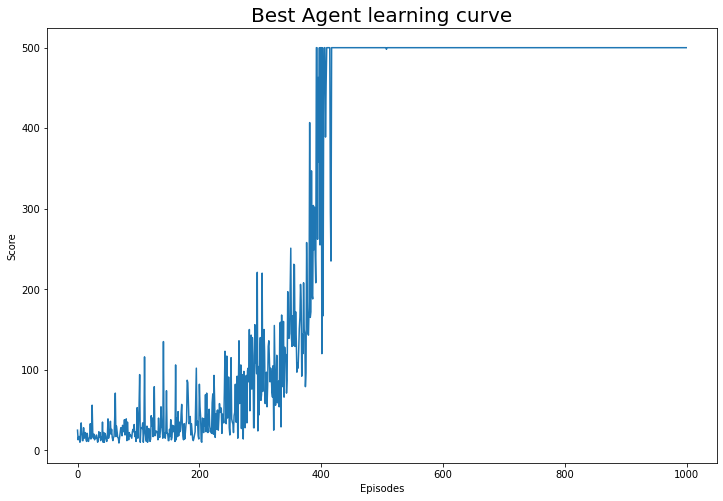

In [66]:
plt.figure(1,figsize=(12,8))
plt.plot(scores)
plt.title("Best Agent learning curve",fontsize=20)
plt.xlabel("Episodes",fontsize=10)
plt.ylabel("Score",fontsize=10)
plt.show()

In [60]:
show_videos()

# 4) 1 other gym env

In [73]:
#env = gym.make("MountainCarContinuous-v0")
env = gym.make("MountainCar-v0")

env.seed(0)

print(env.action_space)
print(env.observation_space)
# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

Discrete(3)
Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

In [74]:
# Define an example network
policy_net = DQN(state_space_dim=2, action_space_dim=3) 

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

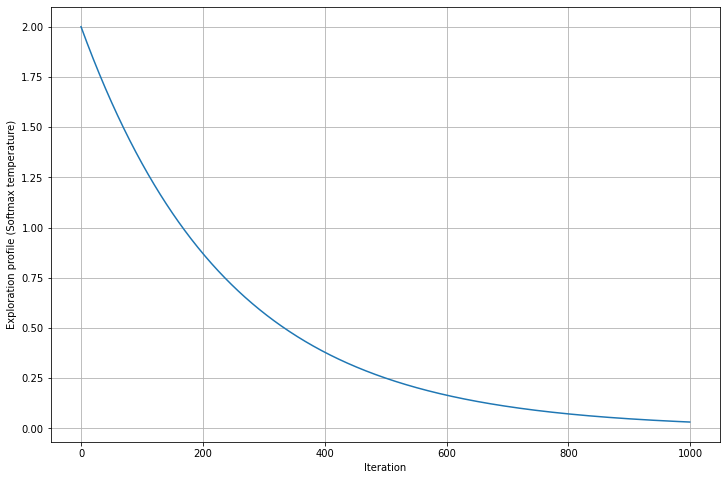

In [75]:
### Define exploration profile
initial_value = 2
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [76]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 5e-2 # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [77]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [78]:
# Initialize the Gym environment
env = gym.make("MountainCar-v0")
env.seed(0)

scores =[]

env = wrap_env(env, video_callable=lambda episode_id: episode_id % 200 == 0) 


for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Action space 
      #0- Accelerate to the left
      #2- Accelerate to the right
  
      #Define the reward 
      if next_state[0] - state[0] > 0 and action == 2: reward += 1
      if next_state[0] - state[0] < 0 and action == 0: reward += 1   
      if next_state[0] >=0.5 : reward += 1 

      # Update the final score 
      score += reward

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None
      
      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    scores.append(score)
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:79: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `rende

Updating target network...
EPISODE: 1 - FINAL SCORE: -129.0 - Temperature: 2.0


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `rende

EPISODE: 2 - FINAL SCORE: -121.0 - Temperature: 1.9916995061889162
EPISODE: 3 - FINAL SCORE: -129.0 - Temperature: 1.9834334614765863
EPISODE: 4 - FINAL SCORE: -132.0 - Temperature: 1.975201722890745
EPISODE: 5 - FINAL SCORE: -129.0 - Temperature: 1.9670041480524967
EPISODE: 6 - FINAL SCORE: -127.0 - Temperature: 1.9588405951738537
EPISODE: 7 - FINAL SCORE: -115.0 - Temperature: 1.9507109230552835


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


EPISODE: 8 - FINAL SCORE: -119.0 - Temperature: 1.9426149910832666


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


EPISODE: 9 - FINAL SCORE: -115.0 - Temperature: 1.934552659227864
EPISODE: 10 - FINAL SCORE: -128.0 - Temperature: 1.9265237880402957
Updating target network...
EPISODE: 11 - FINAL SCORE: -126.0 - Temperature: 1.9185282386505287
EPISODE: 12 - FINAL SCORE: -136.0 - Temperature: 1.9105658727648747
EPISODE: 13 - FINAL SCORE: -135.0 - Temperature: 1.9026365526635982
EPISODE: 14 - FINAL SCORE: -132.0 - Temperature: 1.8947401411985352
EPISODE: 15 - FINAL SCORE: -123.0 - Temperature: 1.88687650179072
EPISODE: 16 - FINAL SCORE: -121.0 - Temperature: 1.8790454984280234
EPISODE: 17 - FINAL SCORE: -126.0 - Temperature: 1.8712469956628
EPISODE: 18 - FINAL SCORE: -119.0 - Temperature: 1.863480858609546
EPISODE: 19 - FINAL SCORE: -123.0 - Temperature: 1.8557469529425652
EPISODE: 20 - FINAL SCORE: -123.0 - Temperature: 1.8480451448936466
Updating target network...
EPISODE: 21 - FINAL SCORE: -126.0 - Temperature: 1.84037530124975
EPISODE: 22 - FINAL SCORE: -127.0 - Temperature: 1.8327372893507023
EPIS

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


EPISODE: 27 - FINAL SCORE: -132.0 - Temperature: 1.7950201013345226


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


EPISODE: 28 - FINAL SCORE: -127.0 - Temperature: 1.7875703247135735
EPISODE: 29 - FINAL SCORE: -125.0 - Temperature: 1.7801514665049925
EPISODE: 30 - FINAL SCORE: -126.0 - Temperature: 1.7727633983897344
Updating target network...
EPISODE: 31 - FINAL SCORE: -129.0 - Temperature: 1.7654059925813095
EPISODE: 32 - FINAL SCORE: -133.0 - Temperature: 1.7580791218235736
EPISODE: 33 - FINAL SCORE: -126.0 - Temperature: 1.7507826593885276
EPISODE: 34 - FINAL SCORE: -130.0 - Temperature: 1.743516479074124
EPISODE: 35 - FINAL SCORE: -123.0 - Temperature: 1.7362804552020854
EPISODE: 36 - FINAL SCORE: -118.0 - Temperature: 1.72907446261573
EPISODE: 37 - FINAL SCORE: -122.0 - Temperature: 1.7218983766778075
EPISODE: 38 - FINAL SCORE: -129.0 - Temperature: 1.714752073268343
EPISODE: 39 - FINAL SCORE: -130.0 - Temperature: 1.7076354287824895
EPISODE: 40 - FINAL SCORE: -124.0 - Temperature: 1.7005483201283913
Updating target network...
EPISODE: 41 - FINAL SCORE: -127.0 - Temperature: 1.693490624725053

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


EPISODE: 64 - FINAL SCORE: -127.0 - Temperature: 1.5390072201608618


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


EPISODE: 65 - FINAL SCORE: -122.0 - Temperature: 1.5326199602077826
EPISODE: 66 - FINAL SCORE: -127.0 - Temperature: 1.5262592089605584
EPISODE: 67 - FINAL SCORE: -119.0 - Temperature: 1.519924856401515
EPISODE: 68 - FINAL SCORE: -133.0 - Temperature: 1.5136167929695785
EPISODE: 69 - FINAL SCORE: -127.0 - Temperature: 1.5073349095583803
EPISODE: 70 - FINAL SCORE: -126.0 - Temperature: 1.5010790975143704
Updating target network...
EPISODE: 71 - FINAL SCORE: -127.0 - Temperature: 1.4948492486349378
EPISODE: 72 - FINAL SCORE: -123.0 - Temperature: 1.488645255166539
EPISODE: 73 - FINAL SCORE: -123.0 - Temperature: 1.4824670098028345
EPISODE: 74 - FINAL SCORE: -131.0 - Temperature: 1.4763144056828323
EPISODE: 75 - FINAL SCORE: -124.0 - Temperature: 1.4701873363890403
EPISODE: 76 - FINAL SCORE: -125.0 - Temperature: 1.4640856959456248
EPISODE: 77 - FINAL SCORE: -126.0 - Temperature: 1.4580093788165782
EPISODE: 78 - FINAL SCORE: -135.0 - Temperature: 1.4519582799038937
EPISODE: 79 - FINAL SCO

/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


EPISODE: 125 - FINAL SCORE: -126.0 - Temperature: 1.1941631870745886


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


EPISODE: 126 - FINAL SCORE: -119.0 - Temperature: 1.1892071150027201
EPISODE: 127 - FINAL SCORE: -127.0 - Temperature: 1.1842716118536316
EPISODE: 128 - FINAL SCORE: -122.0 - Temperature: 1.179356592261215
EPISODE: 129 - FINAL SCORE: -125.0 - Temperature: 1.1744619712136526
EPISODE: 130 - FINAL SCORE: -133.0 - Temperature: 1.1695876640519465
Updating target network...
EPISODE: 131 - FINAL SCORE: -112.0 - Temperature: 1.164733586468455
EPISODE: 132 - FINAL SCORE: -132.0 - Temperature: 1.1598996545054334
EPISODE: 133 - FINAL SCORE: -130.0 - Temperature: 1.1550857845535831
EPISODE: 134 - FINAL SCORE: -125.0 - Temperature: 1.1502918933506043
EPISODE: 135 - FINAL SCORE: -129.0 - Temperature: 1.145517897979756
EPISODE: 136 - FINAL SCORE: -116.0 - Temperature: 1.1407637158684227
EPISODE: 137 - FINAL SCORE: -129.0 - Temperature: 1.1360292647866852
EPISODE: 138 - FINAL SCORE: -125.0 - Temperature: 1.1313144628458993
EPISODE: 139 - FINAL SCORE: -127.0 - Temperature: 1.1266192284972782
EPISODE: 1

KeyboardInterrupt: ignored

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.plot(scores, label='MountainCar')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.grid()
plt.legend()
plt.show()


In [ ]:
show_videos()

In [ ]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      #env.render()
      # Update the final score - check if car reaches the flag
      if next_state[0] - state[0] > 0 and action == 2: reward += 1
      if next_state[0] - state[0] < 0 and action == 0: reward += 1   
      if next_state[0] >=0.5 : reward += 1 
      score = reward
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

EPISODE 1 - FINAL SCORE: -1.0


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `rende

EPISODE 2 - FINAL SCORE: 0.0
EPISODE 3 - FINAL SCORE: -1.0
EPISODE 4 - FINAL SCORE: 0.0
EPISODE 5 - FINAL SCORE: -1.0
EPISODE 6 - FINAL SCORE: -1.0
EPISODE 7 - FINAL SCORE: -1.0


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


EPISODE 8 - FINAL SCORE: -1.0


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


EPISODE 9 - FINAL SCORE: -1.0
EPISODE 10 - FINAL SCORE: -1.0


In [ ]:
show_videos()


SHOWING VIDEO video/rl-video-episode-0.mp4



SHOWING VIDEO video/rl-video-episode-1.mp4



SHOWING VIDEO video/rl-video-episode-1000.mp4



SHOWING VIDEO video/rl-video-episode-125.mp4



SHOWING VIDEO video/rl-video-episode-216.mp4



SHOWING VIDEO video/rl-video-episode-27.mp4



SHOWING VIDEO video/rl-video-episode-343.mp4



SHOWING VIDEO video/rl-video-episode-512.mp4



SHOWING VIDEO video/rl-video-episode-64.mp4



SHOWING VIDEO video/rl-video-episode-729.mp4



SHOWING VIDEO video/rl-video-episode-8.mp4


# Optuna Optimization

In [ ]:
def objective(trial):

  param_dict = {             
  'gamma' : trial.suggest_float('gamma', 0.94, 0.98), #0.97,   # gamma parameter for the long term reward
  'replay_memory_capacity' : 10000,   # Replay memory capacity
  'lr' : trial.suggest_loguniform('lr',1e-3, 5e-1),  # Optimizer learning rate
  'target_net_update_steps' : trial.suggest_categorical('target_net_update_steps', [5,10]), #10,   # Number of episodes to wait before updating the target network
  'batch_size' :  trial.suggest_categorical('batch_size', [128,256]),  # Number of samples to take from the replay memory for each update
  'bad_state_penalty' : trial.suggest_categorical('bad_state_penalty',[0,0.5,1]),   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
  'min_samples_for_training' : 500,  # Minimum samples in the replay memory to enable the training
  'policy' : trial.suggest_categorical('policy',['eps','softmax']),
  'epsilon' : trial.suggest_categorical('epsilon',[0.25,0.5,0.75,1]),
  'tau' : trial.suggest_categorical('tau',[2,4,6,8])
  }

  print("PARAMS:",param_dict)

  env, replay_mem, policy_net, target_net, optimizer, loss = initializer(param_dict)
  scores = training_loop(env,param_dict['policy'],param_dict['epsilon'],param_dict['tau'],num_iterations=500)

  

  return np.mean(scores) #Minimize idx = trial che raggiunge prima il score

In [ ]:
study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="maximize")
study.optimize(objective, n_trials=8, timeout=None, show_progress_bar=False)


save_study = optuna.create_study(study_name="studysave", direction="maximize", storage="sqlite:///mountaincar.db")
save_study.add_trials(study.trials)

In [ ]:
study_load = optuna.load_study(study_name="studysave", storage="sqlite:///mountaincar.db")

df_study = study_load.trials_dataframe(attrs={'number','value', 'duration', 'params', 'state'})
df_study

# 5) 2 other gym env